In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud


In [12]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
uploaded = files.upload()

Saving news_Feb_14.csv to news_Feb_14.csv


In [4]:
# Load dataset
df = pd.read_csv("news_Feb_14.csv")

# Display first few rows
print(df.head())

                                               title        date
0  ECC endorses purchase of $582mn capital shares...  14/02/2025
1  Netanyahu’s statement to establish Palestinian...  14/02/2025
2  India, US agree to resolve trade and tariff ro...  14/02/2025
3  Aurangzeb discusses Pakistan’s structural refo...  14/02/2025
4  HBL, S&P Global launch Pakistan’s first manufa...  14/02/2025


In [ ]:
# Ensure column names are correct
df.columns = [col.strip() for col in df.columns]  #Ensures there are no unwanted leading/trailing spaces in column names.
df = df.dropna(subset=['title'])  #Removes rows where the 'title' column (news headline) is missing to avoid errors in text processing.


In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = text.lower()  #Converts all text to lowercase (text.lower()) to avoid case sensitivity issues (e.g., "Apple" and "apple" should be the same).
    text = re.sub(r'\W+', ' ', text)  #Removes punctuation, numbers, and special symbols to focus on meaningful words.
    tokens = word_tokenize(text)  #Splits text into individual words.
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  #Converts words to their base form (e.g., "running" -> "run").
                                                                                        #Removes common words (e.g., "the", "is") that don’t contribute much meaning.
    return " ".join(tokens)

In [13]:
# Apply preprocessing
df["Processed_title"] = df["title"].apply(preprocess_text)

In [ ]:
# Step 3: Convert Text to Features (BoW, TF-IDF, LSA)
vectorizer_tfidf = TfidfVectorizer(max_features=1000)  # Using TF-IDF
X_tfidf = vectorizer_tfidf.fit_transform(df["Processed_title"])

#TF-IDF (Term Frequency-Inverse Document Frequency) assigns weight based on importance:
# TF-IDF=TFxlog(N/DF) 


In [ ]:
#I used truncatedSVD because when analyzing it performed the best on the dataset
#Converts high-dimensional TF-IDF vectors into a lower-dimensional semantic space.
#n_components=3: Reduces dimensions to 3 key topics.

#Based on previous evaluations, using n_components=3 with k=13 gave the best clustering results.

lsa = TruncatedSVD(n_components=3) 
X_lsa = lsa.fit_transform(X_tfidf)

In [16]:
# Step 4: Cluster Using K-Means
k = 13  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_lsa)

In [ ]:
# Step 5: Evaluate Clustering
wss = [] #WSS (Within-Cluster Sum of Squares): Measures how compact clusters are. Lower WSS-> Better clustering.
sil_scores = [] #Silhouette Score: Measures how well-separated clusters are. Higher silhouette score -> Better-defined clusters.

for i in range(2, 15):  # Try different k values
    km = KMeans(n_clusters=i, random_state=42, n_init=10)
    labels = km.fit_predict(X_lsa)

    wss.append(km.inertia_)  # WSS Score
    sil_scores.append(silhouette_score(X_lsa, labels))  # Silhouette Score

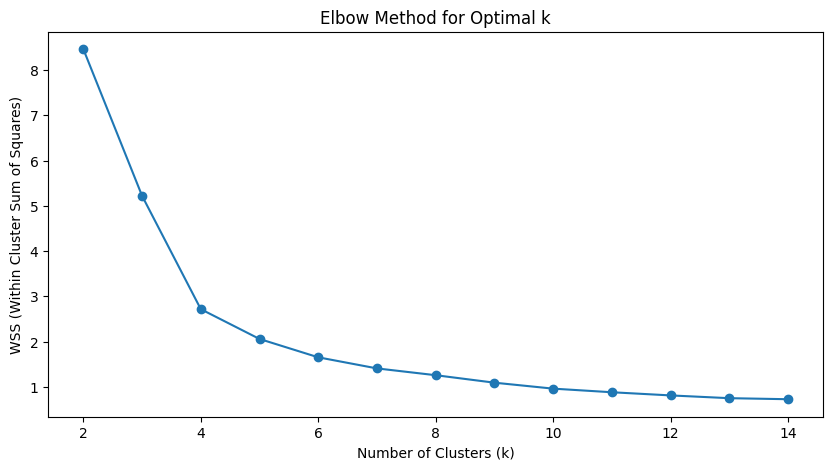

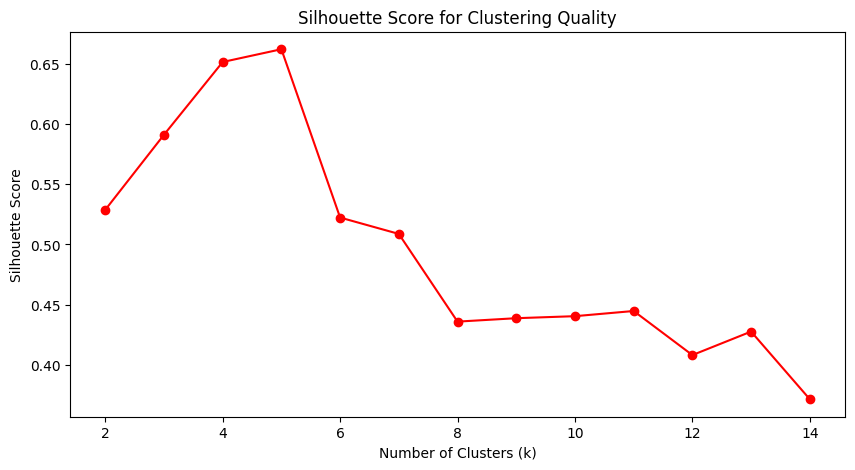

In [18]:
# Plot Elbow Curve
plt.figure(figsize=(10,5))
plt.plot(range(2, 15), wss, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSS (Within Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10,5))
plt.plot(range(2, 15), sil_scores, marker="o", color="red")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Clustering Quality")
plt.show()

In [ ]:
# Step 6: Display Sample Headlines from Each Cluster
for cluster_num in range(k):
    print(f"\n🔹 Cluster {cluster_num}:")
    sample_headlines = df[df["Cluster"] == cluster_num]["title"].sample(n=min(5, len(df[df["Cluster"] == cluster_num])), random_state=42) #min 5 samples
    print(sample_headlines.to_string(index=False))


🔹 Cluster 0:
UAE Blue Visa: Can Pakistanis qualify for 10-ye...
      Aurat March kickstarts in February this year
Balochistan CM announces Pink scooties, electri...
CM Maryam announces 3-marla plots for homeless ...
Sindh govt relaxes timing of ban on entry of he...

🔹 Cluster 1:
Pakistan withdraws key powers from FBR on IMF d...
Top global funds turn to Pakistan as 84% stock ...
Pakistan CPI 2024 – deep-rooted corruption pers...
       US deports migrants from Pakistan to Panama
Turkish President Erdogan reaches PM House for ...

🔹 Cluster 2:
Champions Trophy 2025: squads, groups and schedule
ICC announces prize money breakdown for Champio...
Champions Trophy 2025 Prize Money Breakdown in ...
ICC announces prize money for 2025 Champions Tr...
     List of players to miss Champions Trophy 2025

🔹 Cluster 3:
UK, US agree Zelenskiy must be part of Ukraine ...
South African rand firms after Trump’s tariff m...
India expects $200 million missile deal with Ph...
Economic indicators showin

In [24]:
# Save clustered headlines to a text file
with open("clustered_titles.txt", "w", encoding="utf-8") as f:
    for i in range(k):
        f.write(f"Cluster {i}:\n")
        f.write("-" * 50 + "\n")
        headlines = df[df["Cluster"] == i]["title"].tolist()
        for headline in headlines:
            f.write(headline + "\n")
        f.write("\n")  # Add a new line for better readability

print("Clusters saved to 'clustered_titles.txt' successfully!")


Clusters saved to 'clustered_titles.txt' successfully!
